#### This notebook prepares files to be shared for meabolite detectability prediction analysis (another repo)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

In [2]:
def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df

In [3]:
p_root_dir = Path.cwd().parents[1]
p_data = p_root_dir / "5_data/external_analysis/data_for_detectability_prediction"

# Metrics and Catboost prediction results for individual ions
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset metadata (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_01June2022.csv"

# Compound metadata
p_properties = p_data / "hmdb_multiproperty_2020-09-09.csv"
p_formal_charge = p_data / "hmdb_formal_charge_2020-09-09.csv"
p_compounds_ids = p_data / r"compounds_ids.csv"

### Load predictions for metabolite ions and metadata

In [4]:
# Load predictions
predictions = pd.read_csv(p_predictions)[['dataset_id', 
                                          'name_short', # metabolite name
                                          'adduct', 
                                          'neutral_loss',
                                          'spot_intensity_bgr_corrected', # intensity of the ion in the spot
                                          'pred_val', # probability that the ion image is real signal (and not background noise)
                                          'intensity_vs_far_bg_ratio', # ratio between intensity inside the spot and outside any spot
                                          'occupancy_vs_far_bg_ratio', # ratio between occupancy inside the spot and outside any spot
                                          'bg_occupancy' # % nonzero pixels outside any spot
                                         ]] 
predictions.neutral_loss.fillna('', inplace=True)

# Load dataset metadata
datasets = pd.read_csv(p_datasets)[['Dataset ID', 
                                    'Matrix short', # matrix name
                                    'Polarity'
                                   ]].drop_duplicates()

# Load metabolite metadata (HMDB ID and formal charge)
compounds_ids = pd.read_csv(p_compounds_ids, index_col=0)[['name_short', 'hmdb_primary']]
formal_charge = pd.read_csv(p_formal_charge)


# Merge all
predictions = predictions.merge(
    datasets, left_on='dataset_id', right_on='Dataset ID', how='left').merge(
    compounds_ids, on='name_short', how='left').merge(
    formal_charge, on='hmdb_primary', how='left')

### Clean up

In [5]:
data = predictions

# Filter out PNDI matrix because it did not perform well
data = data[~data['Matrix short'].isin(['PNDI'])]

# Filter out any ions with neutral_losses, because neutral losses are not reflected in fingerprints
data = filter_neutral_losses(data, neutral_losses=[''])

# Filter out some of the metabolites that were not detected by any matrix:
#  indole was volatile
#  others were detectable only in very concentrated form
to_remove = ['Arachidonic acid', 'Phosphoserine', 'Carbamoyl phosphate', 'Indole']
data = data[~data.name_short.isin(to_remove)]

# Define ions with scores above 0.8 as detected
threshold = 0.8
data['detectability'] = data.pred_val >= threshold

# Label ions that are likely to be matrix obscured 
# Current definition of matrix obscured ion is if signal and occupancy ratios 
# between spot and bgr are above 1, and overall background occupancy is above 40%
threshold = 0.8
data['matrix_obscured'] = 0
data.loc[(data.detectability == 0)
            & (data.intensity_vs_far_bg_ratio > 0.95) 
            & (data.occupancy_vs_far_bg_ratio > 0.95)
            & (data.bg_occupancy > 0.4), 'matrix_obscured'] = 1

# Remove columns thta are no longer needed
data.drop(columns=['neutral_loss',  'pred_val', 'intensity_vs_far_bg_ratio', 'occupancy_vs_far_bg_ratio', 'bg_occupancy', 'hmdb_primary', 'formal_charge', 'Dataset ID', 'dataset_id'], inplace=True)

data.head()

,name_short,adduct,spot_intensity_bgr_corrected,Matrix short,Polarity,detectability,matrix_obscured
0,Malic acid,-H,237378.920000,9AA,negative,True,0
8,Malic acid,+Cl,0.000000,9AA,negative,False,0
15,Malic acid,[M]-,-0.119456,9AA,negative,False,0
24,Malic acid,-H,14853.444000,CHCA,negative,True,0
35,Malic acid,[M]-,-0.115587,CHCA,negative,False,0


### Zero-fill

Machine learning classification was applied to all the ion images generated by Metaspace. However, Metaspace did not generate image where there was no signal at all (empty ion image). This means that information about some undetected ions is missing from the predictions file. Here this information is recovered by long-to-wide conversion, nan filling, and reverse wide-to-long conversion

In [6]:
wide_data = data.pivot_table(columns = ['name_short'], 
                             index = ['Matrix short', 'Polarity', 'adduct'],
                             values = ['spot_intensity_bgr_corrected', 'detectability', 'matrix_obscured'],
                             fill_value = 0)

filled_data = wide_data.stack().reset_index()
print(f"{len(filled_data) - len(data)} undetected ions added")

1126 undetected ions added


### Select data following these criteria:

1. If metabolite has any ions that are detected, consider this metabolite detected and calculate mean intensity among detected ions. 
2. If metabolite has no detected ions and no ions are matrix-obscured, consider this metabolite with 0 intensity
3. If metabolite has no detected ions, but some ions are martrix-obscured, exclude such metabolite

One could loop through the data to check for these cases, but here is a faster way to achieve the same

In [7]:
df = filled_data.groupby(['Matrix short', 'Polarity', 'name_short', 'detectability']).agg({
    'matrix_obscured':'max',
    'spot_intensity_bgr_corrected':'sum',
}).reset_index()

df.sort_values(by=['Matrix short', 'Polarity', 'name_short', 'detectability'], ascending=False, inplace=True)

df.head()

,Matrix short,Polarity,name_short,detectability,matrix_obscured,spot_intensity_bgr_corrected
5698,pNA,positive,myo-Inositol,1,0,535.320740
5697,pNA,positive,myo-Inositol,0,0,11.727790
5696,pNA,positive,gamma-Aminobutyric acid,1,0,5219.602610
5695,pNA,positive,gamma-Aminobutyric acid,0,0,-0.021029
5694,pNA,positive,cis-Aconitic acid,1,0,378.709998


In [8]:
df2 = df[df.matrix_obscured == 0]
df2.groupby(['Matrix short', 'Polarity', 'name_short']).agg(list).head() # this line is just for demo

detectability  \
Matrix short Polarity name_short                                   
9AA          negative 2-Oxoglutaric acid                  [1, 0]   
                      3-Hydroxyanthranilic acid           [1, 0]   
                      3-Hydroxymethylglutaric acid           [0]   
                      3-Phosphoglyceric acid              [1, 0]   
                      4,5-Dihydroorotic acid              [1, 0]   

                                                   matrix_obscured  \
Matrix short Polarity name_short                                     
9AA          negative 2-Oxoglutaric acid                    [0, 0]   
                      3-Hydroxyanthranilic acid             [0, 0]   
                      3-Hydroxymethylglutaric acid             [0]   
                      3-Phosphoglyceric acid                [0, 0]   
                      4,5-Dihydroorotic acid                [0, 0]   

                                                   spot_intensity_bgr_corrected  
Matrix short Polarity name_short                                                 
9AA          negative 2-Oxoglutaric acid              [65207.863, -0.066995368]  
                      3-Hydroxyanthranilic acid         [5677.06561, 1.3282442]  
                      3-Hydroxymethylglutaric acid        [-2.6539936600000003]  
                      3-Phosphoglyceric acid           [146078.0, 30.252450189]  
                      4,5-Dihydroorotic acid         [93642.64555, -0.03317374]

In [9]:
df3 = df2.groupby(['name_short', 'Matrix short', 'Polarity']).agg('first').reset_index()
df3.head()

,name_short,Matrix short,Polarity,detectability,matrix_obscured,spot_intensity_bgr_corrected
0,2-Oxoglutaric acid,9AA,negative,1,0,65207.863000
1,2-Oxoglutaric acid,9AA,positive,0,0,-5.381168
2,2-Oxoglutaric acid,CHCA,negative,1,0,1489.384200
3,2-Oxoglutaric acid,CHCA,positive,1,0,72.430640
4,2-Oxoglutaric acid,CMBT,negative,1,0,879.017900


In [10]:
# Most of undetected ions have intensity close to 0, but there are some outliers, to simplify, I set them to 0
print(df3.loc[df3.detectability==0, 'spot_intensity_bgr_corrected'].describe())
df3.loc[df3.detectability==0, 'spot_intensity_bgr_corrected'] = 0

count     1497.000000
mean        35.354962
std        449.048716
min      -7962.428473
25%         -0.036729
50%          0.516135
75%         13.785376
max      11588.425070
Name: spot_intensity_bgr_corrected, dtype: float64


In [11]:
result = df3.copy().drop(columns='matrix_obscured').rename(columns={'spot_intensity_bgr_corrected':'intensity'})
result['log10_intensity'] = np.log10(result['intensity']+1)
result.head()

,name_short,Matrix short,Polarity,detectability,intensity,log10_intensity
0,2-Oxoglutaric acid,9AA,negative,1,65207.86300,4.814307
1,2-Oxoglutaric acid,9AA,positive,0,0.00000,0.000000
2,2-Oxoglutaric acid,CHCA,negative,1,1489.38420,3.173298
3,2-Oxoglutaric acid,CHCA,positive,1,72.43064,1.865877
4,2-Oxoglutaric acid,CMBT,negative,1,879.01790,2.944492


### Save

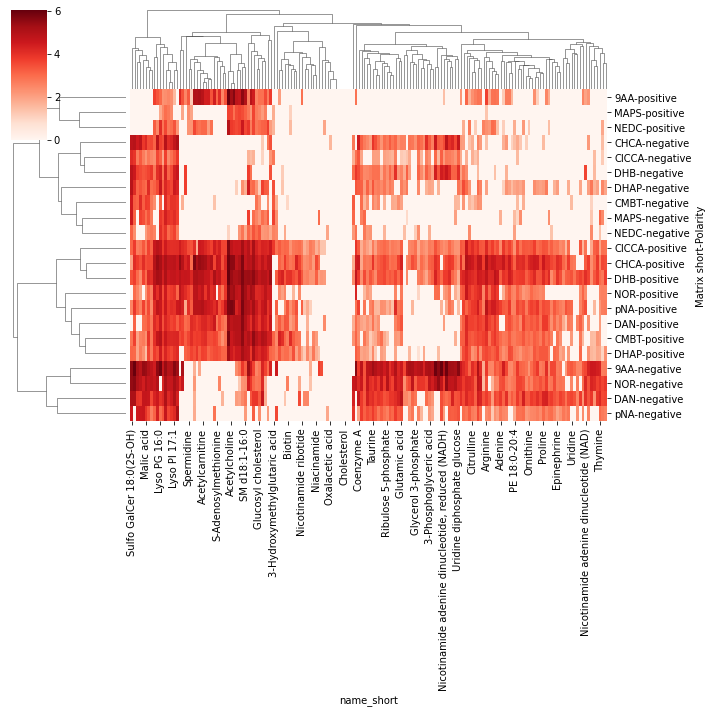

In [12]:
# test
sns.clustermap(result.pivot_table(index=['Matrix short', 'Polarity'],
                              columns=['name_short'],
                              values='log10_intensity', fill_value=0), cmap='Reds')

In [13]:
result.to_csv(p_analysis / r"11july_metabolite_matrix_polarity.csv") # including all compounds with formal charge other than 1 and all adducts

## Alternative 1: Prepare subset of the data excluding metabolites with formal charge and radical adducts

In [15]:
data = predictions

# Filter out PNDI matrix because it did not perform well
data = data[~data['Matrix short'].isin(['PNDI'])]

# # Filter out metabolites with nozero formal charge (HMDB), e.g. thiamine
data = data[data.formal_charge==0]

# # Filter out adducts that are radicals (M+ or M-)
data = filter_adducts(data, adducts=['+H', '+K', '+Na', '+Cl', '-H'])

# Filter out any ions with neutral_losses, because neutral losses are not reflected in fingerprints
data = filter_neutral_losses(data, neutral_losses=[''])

# Filter out some of the metabolites that were not detected by any matrix:
#  indole was volatile
#  others were detectable only in very concentrated form
to_remove = ['Arachidonic acid', 'Phosphoserine', 'Carbamoyl phosphate', 'Indole']
data = data[~data.name_short.isin(to_remove)]

# Define ions with scores above 0.8 as detected
threshold = 0.8
data['detectability'] = data.pred_val >= threshold

# Label ions that are likely to be matrix obscured 
# Current definition of matrix obscured ion is if signal and occupancy ratios 
# between spot and bgr are above 1, and overall background occupancy is above 40%
threshold = 0.8
data['matrix_obscured'] = 0
data.loc[(data.detectability == 0)
            & (data.intensity_vs_far_bg_ratio > 0.95) 
            & (data.occupancy_vs_far_bg_ratio > 0.95)
            & (data.bg_occupancy > 0.4), 'matrix_obscured'] = 1

# Remove columns thta are no longer needed
data.drop(columns=['neutral_loss',  'pred_val', 'intensity_vs_far_bg_ratio', 'occupancy_vs_far_bg_ratio', 'bg_occupancy', 'hmdb_primary', 'formal_charge', 'Dataset ID', 'dataset_id'], inplace=True)


wide_data = data.pivot_table(columns = ['name_short'], 
                             index = ['Matrix short', 'Polarity', 'adduct'],
                             values = ['spot_intensity_bgr_corrected', 'detectability', 'matrix_obscured'],
                             fill_value = 0)

filled_data = wide_data.stack().reset_index()


df = filled_data.groupby(['Matrix short', 'Polarity', 'name_short', 'detectability']).agg({
    'matrix_obscured':'max',
    'spot_intensity_bgr_corrected':'sum',
}).reset_index()

df.sort_values(by=['Matrix short', 'Polarity', 'name_short', 'detectability'], ascending=False, inplace=True)
df2 = df[df.matrix_obscured == 0]
df3 = df2.groupby(['name_short', 'Matrix short', 'Polarity']).agg('first').reset_index()
df3.loc[df3.detectability==0, 'spot_intensity_bgr_corrected'] = 0
result = df3.copy().drop(columns='matrix_obscured').rename(columns={'spot_intensity_bgr_corrected':'intensity'})
result['log10_intensity'] = np.log10(result['intensity']+1)

result.to_csv(p_analysis / r"11july_metabolite_matrix_polarity_no_radicals.csv") # excluding all compounds with formal charge other than 1 and all radical adducts

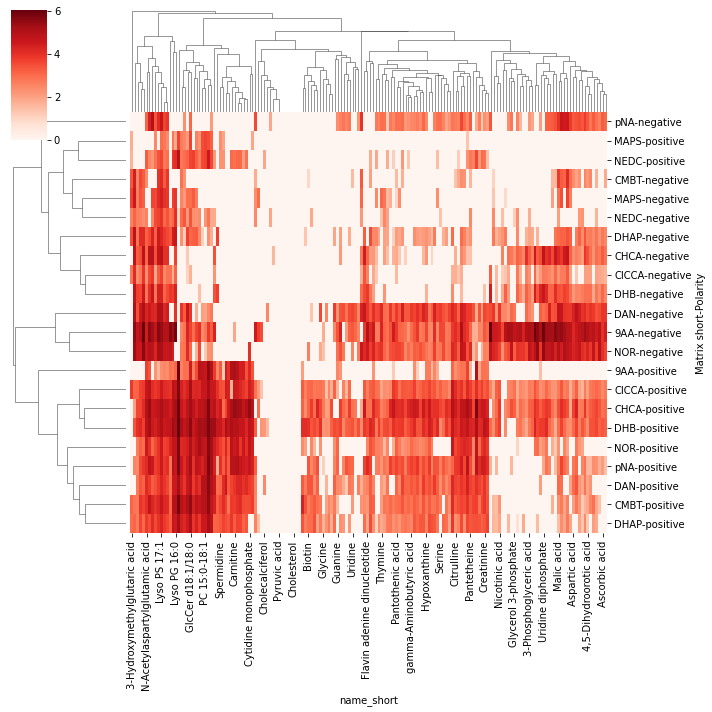

In [16]:
# test
sns.clustermap(result.pivot_table(index=['Matrix short', 'Polarity'],
                              columns=['name_short'],
                              values='log10_intensity', fill_value=0), cmap='Reds')

## Alternative 2: Only consider protonation and deprotonation events

In [17]:
data = predictions

# Filter out PNDI matrix because it did not perform well
data = data[~data['Matrix short'].isin(['PNDI'])]

# Filter out metabolites with nozero formal charge (HMDB), e.g. thiamine
data = data[data.formal_charge==0]

# Filter adducts 
data = filter_adducts(data, adducts=['+H', '-H'])

# Filter out any ions with neutral_losses, because neutral losses are not reflected in fingerprints
data = filter_neutral_losses(data, neutral_losses=[''])

# Filter out some of the metabolites that were not detected by any matrix:
#  indole was volatile
#  others were detectable only in very concentrated form
to_remove = ['Arachidonic acid', 'Phosphoserine', 'Carbamoyl phosphate', 'Indole']
data = data[~data.name_short.isin(to_remove)]

# Define ions with scores above 0.8 as detected
threshold = 0.8
data['detectability'] = data.pred_val >= threshold

# Label ions that are likely to be matrix obscured 
# Current definition of matrix obscured ion is if signal and occupancy ratios 
# between spot and bgr are above 1, and overall background occupancy is above 40%
threshold = 0.8
data['matrix_obscured'] = 0
data.loc[(data.detectability == 0)
            & (data.intensity_vs_far_bg_ratio > 0.95) 
            & (data.occupancy_vs_far_bg_ratio > 0.95)
            & (data.bg_occupancy > 0.4), 'matrix_obscured'] = 1

# Remove columns thta are no longer needed
data.drop(columns=['neutral_loss',  'pred_val', 'intensity_vs_far_bg_ratio', 'occupancy_vs_far_bg_ratio', 'bg_occupancy', 'hmdb_primary', 'formal_charge', 'Dataset ID', 'dataset_id'], inplace=True)


wide_data = data.pivot_table(columns = ['name_short'], 
                             index = ['Matrix short', 'Polarity', 'adduct'],
                             values = ['spot_intensity_bgr_corrected', 'detectability', 'matrix_obscured'],
                             fill_value = 0)

filled_data = wide_data.stack().reset_index()


df = filled_data.groupby(['Matrix short', 'Polarity', 'name_short', 'detectability']).agg({
    'matrix_obscured':'max',
    'spot_intensity_bgr_corrected':'sum',
}).reset_index()

df.sort_values(by=['Matrix short', 'Polarity', 'name_short', 'detectability'], ascending=False, inplace=True)
df2 = df[df.matrix_obscured == 0]
df3 = df2.groupby(['name_short', 'Matrix short', 'Polarity']).agg('first').reset_index()
df3.loc[df3.detectability==0, 'spot_intensity_bgr_corrected'] = 0
result = df3.copy().drop(columns='matrix_obscured').rename(columns={'spot_intensity_bgr_corrected':'intensity'})
result['log10_intensity'] = np.log10(result['intensity']+1)

result.to_csv(p_analysis / r"11july_metabolite_matrix_polarity_only_protons.csv") # excluding all compounds with formal charge other than 1 and all radical adducts

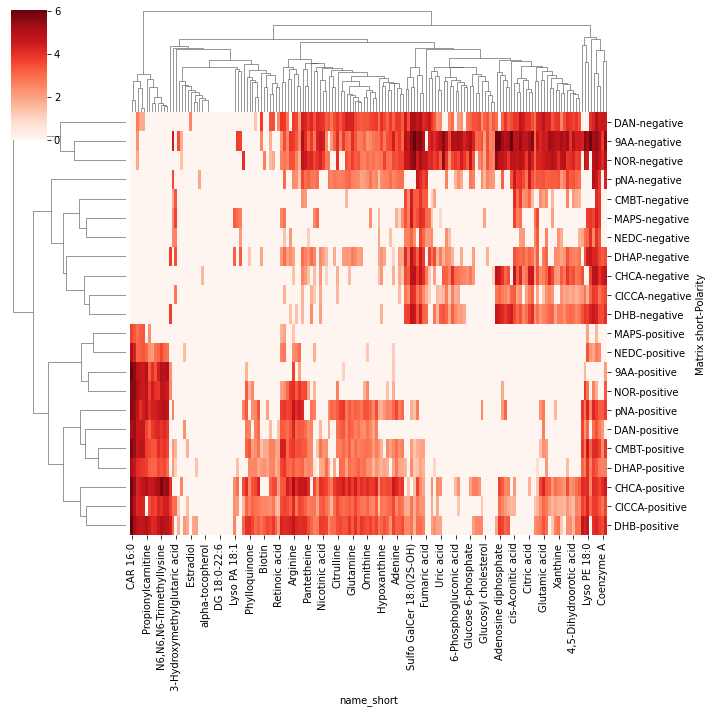

In [18]:
# test
sns.clustermap(result.pivot_table(index=['Matrix short', 'Polarity'],
                              columns=['name_short'],
                              values='log10_intensity', fill_value=0), cmap='Reds')

## Prepare features

In [ ]:
properties = pd.read_csv(p_properties)
physchem_data = compounds_ids.merge(properties, how='left', on='hmdb_primary').drop(columns=['hmdb_primary', 'smiles'])
physchem_data.to_csv(p_analysis / 'physchem_properties.csv', index=False)

In [ ]:
fingerprint = pd.read_csv(r"D:\saharuka\spotting\20_matrices_git\spotting\analysis\20_matrices\5_data_analysis\data_for_sharing\Martijn\fingerprints.csv", index_col=0)
fingerprint = fingerprint.loc[:, fingerprint.sum()>0]
fingerprint = fingerprint.reset_index().rename(columns={'mol_name':'name_short'})
fingerprint.to_csv(p_analysis / 'fingerprints.csv', index=False)